In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.utils import shuffle
import common_functions as cf
import importlib
importlib.reload(cf)

<module 'common_functions' from 'd:\\Work\\Programming\\Jupyter\\Traffic Object Detection\\common_functions.py'>

In [2]:
# Input Folders
main_folder = 'dataset/traffic_object_detection'
train_folder = f'{main_folder}/train'
test_folder = f'{main_folder}/test'
valid_folder = f'{main_folder}/valid'

classes = ['bicycle', 'bus', 'car', 'motorbike', 'person']
colors = [[0, 0, 255], [255, 0, 0], [0, 255, 0], [200, 200, 0], [200, 200, 200]]

aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.txt aguanambi-1085_png_jpg.rf.ba8bcc4fd6c7cae9f610e611e300bdf1.jpg


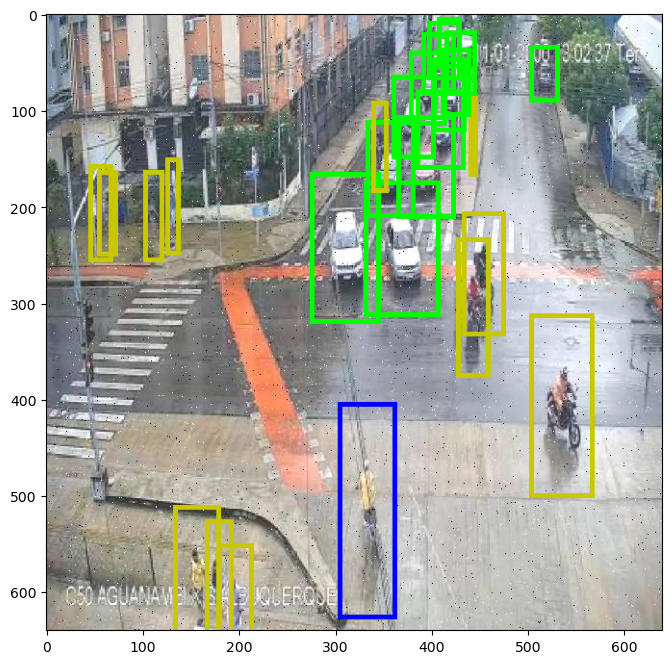

In [3]:
# Loading data
image_index = 5
images = os.listdir(f'{train_folder}/images')
labels = os.listdir(f'{train_folder}/labels')
image = plt.imread(f'{train_folder}/images/{images[image_index]}')
label = ''
object_coordinates = []
with open(f'{train_folder}/labels/{labels[image_index]}', 'r') as file:
    label = file.readlines()
new_image = image.copy()
for lab in label:
    coordinates = [float(num) for num in lab.split(' ')]
    new_image, coords = cf.draw_boundary(new_image, colors[int(coordinates[0])], coordinates, False)
    object_coordinates.append(coords)

print(labels[image_index], images[image_index])

plt.figure(figsize=(8, 8))
plt.imshow(new_image)

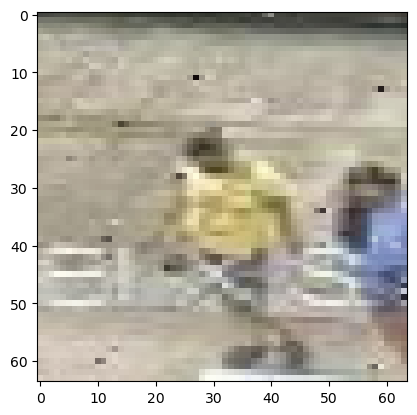

In [4]:
cropped_image = cf.resize_region(image, object_coordinates[0][1], object_coordinates[0][2], object_coordinates[0][3], object_coordinates[0][4])
plt.imshow(cropped_image)

# Data Generator

In [20]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, folder, batch_size, shuffle=True):
        self.folder = folder
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.images = os.listdir(f'{folder}/images')
        self.labels = os.listdir(f'{folder}/labels')
        self.on_epoch_end()
    
    def on_epoch_end(self):
        if self.shuffle:
            self.images, self.labels = shuffle(self.images, self.labels)

    def __len__(self):
        return int(len(self.images) / self.batch_size)

    def __getitem__(self, index):
        i = index
        X = []
        y = []
        region_ratios = [[1, 1], [2, 1]]
        region_scales = [16, 32, 48, 64]
        while len(X) == 0:
            batch_images = self.images[i * self.batch_size:(i + 1) * self.batch_size]
            batch_labels = self.labels[i * self.batch_size:(i + 1) * self.batch_size]
            X = []
            y = []
            # y2 = []
            for j in range(self.batch_size):
                image, object_coordinates = cf.load_image(self.folder, batch_images, batch_labels, j)
                if len(object_coordinates) == 0:
                    continue
                regions = cf.propose_train_regions(object_coordinates)
                for object_coords in regions:
                    if not cf.is_region_inside_image(image, object_coords[1], object_coords[2], object_coords[3], object_coords[4]):
                        continue

                    cropped_image = cf.resize_region(image, object_coords[1], object_coords[2], object_coords[3], object_coords[4], (96, 96))
                    X.append(cropped_image)
                    y.append(int(object_coords[0]))
                    # y2.append(object_coords[1:])

            X = np.asarray(X).astype('float32')
            X = X / 255.
            y = np.array(y, dtype='int32')
            # y = {
            #     'classifier': np.array(y1, dtype='int32'),
            #     'boundary_definer': np.array(y2, dtype='float32')
            # }
            i += 1

            if i >= len(self.images) - self.batch_size:
                i = np.random.randint(0, self.__len__())

        return X, y

In [21]:
train_generator = ImageGenerator(train_folder, 10, True)
valid_generator = ImageGenerator(valid_folder, 2)
test_generator = ImageGenerator(test_folder, 2)

# Defining & Training Model

In [22]:
# Using the pretrained CNN model
vgg16 = VGG16(include_top=False, 
                           input_shape=(96, 96, 3),
                           weights='imagenet')

for layer in vgg16.layers:
    layer.trainable = False

last_vgg16_layer = vgg16.layers[-1]
last_vgg16_output = last_vgg16_layer.output
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [23]:
# Using the pretrained CNN model
inception_v3 = InceptionV3(include_top=False, 
                           input_shape=(128, 128, 3),
                           weights='imagenet')

for layer in inception_v3.layers:
    layer.trainable = False

last_inception_layer = inception_v3.get_layer('mixed7')
last_inception_output = last_inception_layer.output
inception_v3.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

In [27]:
x = last_vgg16_output
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(units=32, activation='relu')(x)
out = Dense(units=len(classes), activation='softmax', name='classifier')(x)
model = Model(vgg16.input, out)
model.compile(loss={'classifier': 'sparse_categorical_crossentropy'}, optimizer='adam', metrics={'classifier': 'accuracy'})
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

In [28]:
model_checkpoint = ModelCheckpoint("checkpoints/rcnn.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')
history = model.fit(train_generator, epochs=10, steps_per_epoch=50, validation_data=valid_generator, validation_steps=100, callbacks=[model_checkpoint])

Epoch 1/10
50/50 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.7376
Epoch 1: val_loss improved from inf to 0.43209, saving model to checkpoints\rcnn.h5
50/50 [==============================] - 156s 3s/step - loss: 0.7170 - accuracy: 0.7376 - val_loss: 0.4321 - val_accuracy: 0.8684
Epoch 2/10
50/50 [==============================] - ETA: 0s - loss: 0.4172 - accuracy: 0.8630
Epoch 2: val_loss improved from 0.43209 to 0.40528, saving model to checkpoints\rcnn.h5
50/50 [==============================] - 55s 1s/step - loss: 0.4172 - accuracy: 0.8630 - val_loss: 0.4053 - val_accuracy: 0.8825
Epoch 3/10
50/50 [==============================] - ETA: 0s - loss: 0.3929 - accuracy: 0.8738
Epoch 3: val_loss improved from 0.40528 to 0.34370, saving model to checkpoints\rcnn.h5
50/50 [==============================] - 105s 2s/step - loss: 0.3929 - accuracy: 0.8738 - val_loss: 0.3437 - val_accuracy: 0.8827
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0

In [29]:
model.evaluate(test_generator)

139/139 [==============================] - 11s 77ms/step - loss: 0.1693 - accuracy: 0.9414


[0.16932673752307892, 0.9413580298423767]

In [23]:
# Saving the model
model.save('classification_network.h5')

In [30]:
best_model = load_model('checkpoints/rcnn.h5')

Text(0, 0.5, 'Loss')

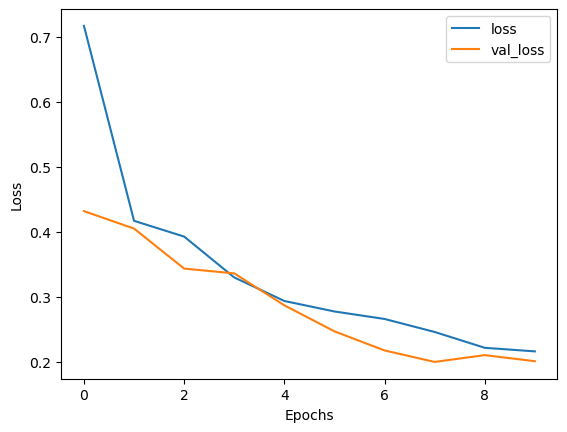

In [31]:
# Plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss', 'classifier_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

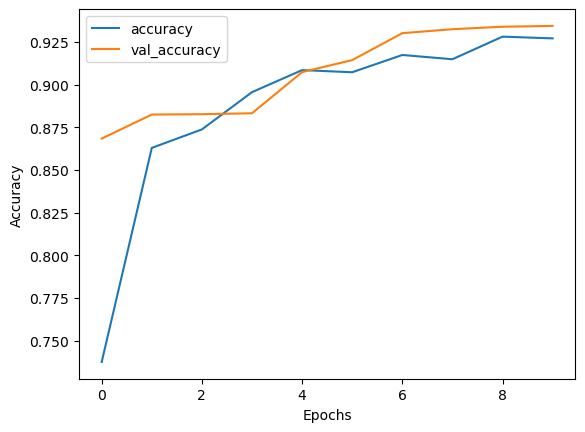

In [32]:
# Plotting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['classifier_accuracy'])
# plt.plot(history.history['boundary_definer_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

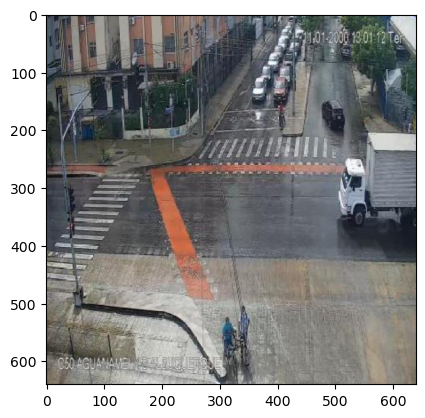

In [6]:
test_images = os.listdir(f'{test_folder}/images')
test_labels = os.listdir(f'{test_folder}/labels')
test_image, test_objects_coords = cf.load_image(test_folder, test_images, test_labels, 0)
object_index = 0
upscaled_coords = test_objects_coords[object_index]
modified_image = test_image.copy()
modified_image, coords = cf.draw_boundary(modified_image, [255, 0, 0], test_objects_coords[object_index], False)
plt.imshow(modified_image)

(1, 96, 96, 3)


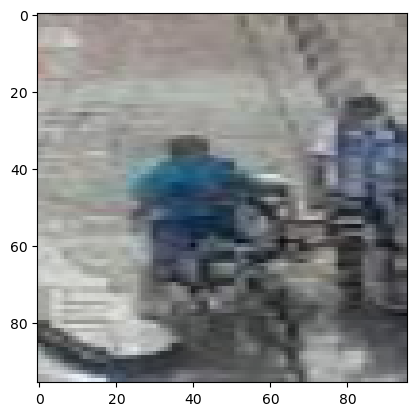

In [34]:
test_cropped_image = cf.resize_region(test_image, upscaled_coords[1], upscaled_coords[2], upscaled_coords[3], upscaled_coords[4], (96, 96))
plt.imshow(test_cropped_image)
test_cropped_image = np.reshape(test_cropped_image, (1, 96, 96, 3))
print(test_cropped_image.shape)

In [35]:
predictions = model.predict(test_cropped_image)

1/1 [==============================] - 0s 464ms/step


Actual Class: bicycle
Predicted Class: car


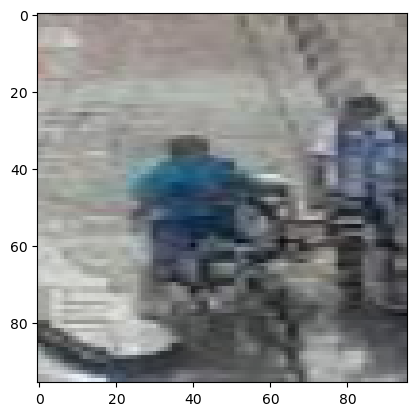

In [36]:
predicted_class = np.argmax(predictions)
print(f'Actual Class: {classes[upscaled_coords[0]]}')
print(f'Predicted Class: {classes[predicted_class]}')
plt.imshow(test_cropped_image[0])

# Combining both models for final Result

In [3]:
rpn = load_model('checkpoints/region_proposal_network.h5')
classifier = load_model('checkpoints/rcnn.h5')

In [4]:
for class_name, color in zip(classes, colors):
    print(f'{class_name} -> {color}')

bicycle -> [0, 0, 255]
bus -> [255, 0, 0]
car -> [0, 255, 0]
motorbike -> [200, 200, 0]
person -> [200, 200, 200]


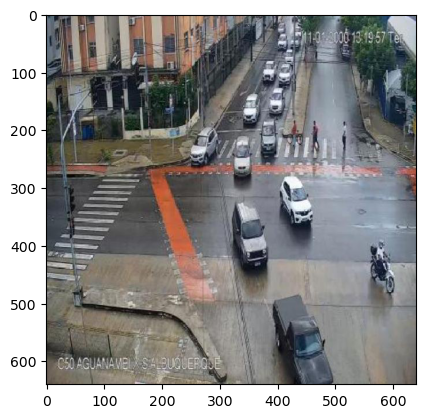

In [8]:
img_index = 7
image, object_coords = cf.load_image(test_folder, test_images, test_labels, img_index)
plt.imshow(image)

In [14]:
region_ratios = [[1, 1], [2, 1]]
region_scales = [32, 48, 64]
detected_regions, detected_classes = cf.detect_objects(image, rpn, classifier, 0.85)

249/249 [==============================] - 62s 249ms/step
Proposed Regions: 68 out of 7965
3/3 [==============================] - 1s 627ms/step
Final Regions: 6


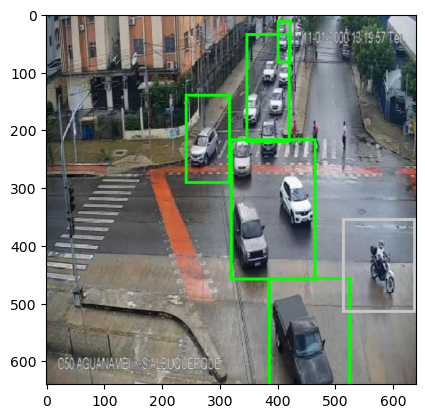

In [16]:
copied_image = image.copy()
for region, region_class in zip(detected_regions, detected_classes):
    copied_image = cf.draw_boundary(copied_image, colors[region_class], region, True, False)
plt.imshow(copied_image)

Text(0.5, 1.0, 'Predicted Class: car')

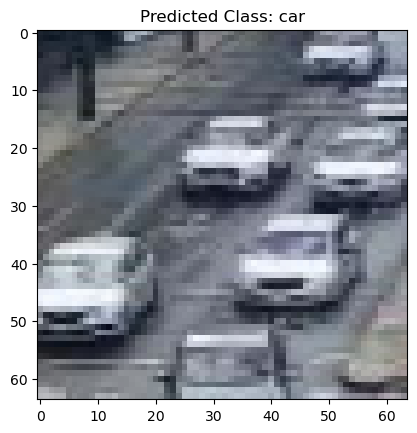

In [20]:
region_index = 3
selected_region = detected_regions[region_index]
resized_image =  cf.resize_region(image, selected_region[0], selected_region[1], selected_region[2], selected_region[3])
plt.imshow(resized_image)
plt.title(f'Predicted Class: {classes[detected_classes[region_index]]}')